### 潜变量自回归模型
> 使用潜变量$h_t$总结过去信息：$p(h_t|h_{t-1}, x_{t-1}),p(s_t|h_t,x_{t-1})$
![](../images/LatentVariableModel.png)

### 循环神经网络
> * 更新隐藏状态：$h_t=\phi(W_{hh}h_{t-1}+W_{hx}x_{t-1}+b_h)$
> * 输出：$o_t=W_{ho}h_t+b_o$
![](../images/RNN.png)

### 困惑度（perplexity）
> * 衡量一个语言模型的好坏可以使用平均交叉熵:$\pi =\frac{1}{n}\sum_{t=1}^n-logp(x_t|x_{t-1},...)$，p是语言模型的预测概率，$x_t$是真实词。
> * 历史原因NLP使用困惑度$exp(\pi)$来衡量，是平均每次可能的选项
>> * 1表示完美，无穷大是最差情况

### 梯度裁剪
> * 迭代中计算这T个时间步上的梯度，在反向转播过程中产生长度为$O(T)$的矩阵乘法链，导致数值不稳定
> * 梯度裁剪能有效预防梯度爆炸
>> * 如果梯度长度超过$\theta$，那么投影回长度$\theta$。$g\leftarrow min(1, \frac{\theta}{||g||})g$，$g$是所有时间步长上的梯度和，$||g||$可以得到时间步长，所以如果时间步长过大的话，会将梯度压缩到$\theta$这个时间步长内

### RNN应用
> * 文本生成（one to many）
> * 文本分类（many to one）
> * 问答、机器翻译（many to many）
> * tag生成（many to many）

### 总结
> * 循环神经网络的输出取决于当下输入和前一时间的隐变量
> * 应用到语言模型中时间，循环神经网络根据当前词语预测下一次时刻词
> * 通常使用困惑度来衡量语言模型的好坏

In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import limutorch as d2l

batch_size, num_steps= 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
"""独热编码"""
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [5]:
"""小批量数据形状（批量大小，时间步数）"""
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [6]:
"""初始化循环神经网络模型的参数"""
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs =vocab_size

    def normal(shape):
        return  torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [7]:
"""init_tnn_state函数在初始化时返回隐藏状态，即需要给出刚开始的潜变量"""
def init_rnn_state(batch_size, num_hiddens, decive):
    return (torch.zeros((batch_size, num_hiddens), device=decive), )

In [8]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H,  = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, )

In [9]:
"""创建一个类来包装这些函数"""
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [10]:
"""检查输出是有具有正确的形状"""
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [20]:
"""定义预测函数来生成prefix之后的新字符"""
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在‘prefix’后面生成新的字符"""
    # state先初始化为0，后续会将根据输入语句对state进行更新，然后再进行预测
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [21]:
"""尚未训练"""
predict_ch8('time traveller', 10, net, vocab, d2l.try_gpu())

'time traveller for so it'

In [22]:
"""梯度裁剪"""
def grad_clipping(net, theta):
    """梯度裁剪"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 对所有梯度平方求和开根号，相当于求||g||
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    # 如果norm>theta，更新梯度
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [23]:
"""在训练模型之前，定义一个函数在一个迭代周期内训练模型"""
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # 当测试集是连续的，仅仅保留之前训练的最后一个state，而断开之前的线性链接
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [24]:
"""训练函数"""
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr=lr)
    else:
        updater = lambda batch_size:d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix:predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度{ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度1.0, 31048.4 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


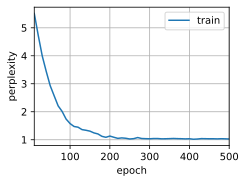

In [25]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度1.5, 36193.7 词元/秒 cuda:0
time travellerit s against reason said filbywos seaw thing so a 
travellerit s against reason said filbywos seaw thing so a 


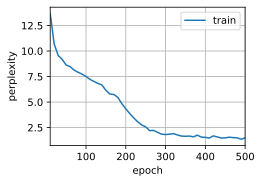

In [27]:
"""使用随机抽样"""
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)

In [11]:
"""简洁实现"""
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [12]:
"""使用张量来初始化隐藏状态"""
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 512])

In [13]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y , state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 512]), torch.Size([1, 32, 512]))

In [16]:
class RNNModel(nn.Module):
    """循环神经网络"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的，num_directions应该是2，否则是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为（时间步数*批量大小，隐藏单元），他的输出形状是（时间步数*批量大小，词表大小）
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                               batch_size, self.num_hiddens), device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                               batch_size, self.num_hiddens), device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device))

In [26]:
"""训练与预测"""
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time traveller <unk>jsydtv <unk>'

困惑度1.0, 173712.5 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


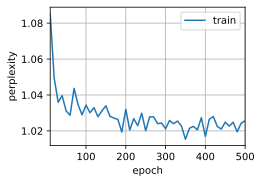

In [27]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)